Source: https://www.kaggle.com/c/allstate-claims-severity

# How severe is an insurance claim?

When you’ve been devastated by a serious car accident, your focus is on the things that matter the most: family, friends, and other loved ones. Pushing paper with your insurance agent is the last place you want your time or mental energy spent. This is why Allstate, a personal insurer in the United States, is continually seeking fresh ideas to improve their claims service for the over 16 million households they protect.

Allstate is currently developing automated methods of predicting the cost, and hence severity, of claims. In this recruitment challenge, Kagglers are invited to show off their creativity and flex their technical chops by creating an algorithm which accurately predicts claims severity. Aspiring competitors will demonstrate insight into better ways to predict claims severity for the chance to be part of Allstate’s efforts to ensure a worry-free customer experience.

## Data Files

|       File Name        |      Format       |
|------------------------|-------------------|
| sample_submission.csv  |  .zip (290.61 kb) |
| train.csv	             |  .zip (13.17 mb)  |
| test.csv               | .zip (8.17 mb)    |

Each row in this dataset represents an insurance claim. You must predict the value for the 'loss' column. Variables prefaced with 'cat' are categorical, while those prefaced with 'cont' are continuous.

### File descriptions

- `train.csv` - the training set
- `test.csv` - the test set. You must predict the loss value for the ids in this file.
- `sample_submission.csv` - a sample submission file in the correct format

# Data Location

Data are stored on HDFS under `/gsemet/allstate`

# Notebook execution

By default, this notebook will execute normally fast, with boosting limited to a smaill number of rounds.

If you want to run this notebook with more rounds:

- First, restart the kernel
- Execute the cell bellow only **ONCE** to have the slider appear
- Move this slider to change the default max number of rounds executed during the boost.
- Then select the next cell and have the rest of the notebook executed with the command `[Cell] > [Run All Bellow]`.

In [1]:
from ipywidgets import IntSlider, interact
from IPython.display import display

num_boost_round = 300

num_boost_round_slider = IntSlider(min=30, max=10000, step=10, value=100)

display(num_boost_round_slider)

**Once the value of the slider is set, select this cell and then execute all cell bellow with `[Cell] > [Run All Bellow]`**

# Challenge

In [2]:
from subprocess import getstatusoutput

_, files = getstatusoutput("hadoop fs -ls /gsemet/allstate")
files.split("\n")

['Found 7 items',
 '-rw-r--r--   3 gsemet supergroup         69 2016-10-11 11:12 /gsemet/allstate/README',
 '-rw-r--r--   3 gsemet supergroup    1106039 2016-10-11 11:19 /gsemet/allstate/sample_submission.csv',
 '-rw-r--r--   3 gsemet supergroup     297588 2016-10-11 11:12 /gsemet/allstate/sample_submission.csv.zip',
 '-rw-r--r--   3 gsemet supergroup   45715862 2016-10-11 11:19 /gsemet/allstate/test.csv',
 '-rw-r--r--   3 gsemet supergroup    8568293 2016-10-11 11:13 /gsemet/allstate/test.csv.zip',
 '-rw-r--r--   3 gsemet supergroup   70025339 2016-10-11 11:19 /gsemet/allstate/train.csv',
 '-rw-r--r--   3 gsemet supergroup   13806188 2016-10-11 11:12 /gsemet/allstate/train.csv.zip']

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font_scale = 1.5)
pd.set_option('display.max_columns', 500)

train = pd.read_csv('/mnt/hdfs/gsemet/allstate/train.csv')
test  = pd.read_csv('/mnt/hdfs/gsemet/allstate/test.csv')

In [4]:
print("Train:", train.shape)
print("Test: ", test.shape)

Train: (188318, 132)
Test:  (125546, 131)


Both look similar in size. Let's look at the start of each dataframe

In [5]:
train.head()

,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,cat11,cat12,cat13,cat14,cat15,cat16,cat17,cat18,cat19,cat20,cat21,cat22,cat23,cat24,cat25,cat26,cat27,cat28,cat29,cat30,cat31,cat32,cat33,cat34,cat35,cat36,cat37,cat38,cat39,cat40,cat41,cat42,cat43,cat44,cat45,cat46,cat47,cat48,cat49,cat50,cat51,cat52,cat53,cat54,cat55,cat56,cat57,cat58,cat59,cat60,cat61,cat62,cat63,cat64,cat65,cat66,cat67,cat68,cat69,cat70,cat71,cat72,cat73,cat74,cat75,cat76,cat77,cat78,cat79,cat80,cat81,cat82,cat83,cat84,cat85,cat86,cat87,cat88,cat89,cat90,cat91,cat92,cat93,cat94,cat95,cat96,cat97,cat98,cat99,cat100,cat101,cat102,cat103,cat104,cat105,cat106,cat107,cat108,cat109,cat110,cat111,cat112,cat113,cat114,cat115,cat116,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
0,1,A,B,A,B,A,A,A,A,B,A,B,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,D,B,B,D,D,B,D,C,B,D,B,A,A,A,A,A,D,B,C,E,A,C,T,B,G,A,A,I,E,G,J,G,BU,BC,C,AS,S,A,O,LB,0.726300,0.245921,0.187583,0.789639,0.310061,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843,2213.18
1,2,A,B,A,A,A,A,A,A,B,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,D,B,B,D,D,A,B,C,B,D,B,A,A,A,A,A,D,D,C,E,E,D,T,L,F,A,A,E,E,I,K,K,BI,CQ,A,AV,BM,A,O,DP,0.330514,0.737068,0.592681,0.614134,0.885834,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496,1283.60
2,5,A,B,A,A,B,A,A,A,B,B,B,B,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,D,B,B,B,D,B,D,C,B,B,B,A,A,A,A,A,D,D,C,E,E,A,D,L,O,A,B,E,F,H,F,A,AB,DK,A,C,AF,A,I,GK,0.261841,0.358319,0.484196,0.236924,0.397069,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425,3005.09
3,10,B,B,A,B,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,D,B,B,D,D,D,B,C,B,D,B,A,A,A,A,A,D,D,C,E,E,D,T,I,D,A,A,E,E,I,K,K,BI,CS,C,N,AE,A,O,DJ,0.321594,0.555782,0.527991,0.373816,0.422268,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642,939.85
4,11,A,B,A,B,A,A,A,A,B,B,A,B,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,D,B,D,B,D,B,B,C,B,B,C,A,A,A,B,H,D,B,D,E,E,A,P,F,J,A,A,D,E,K,G,B,H,C,C,Y,BM,A,K,CK,0.273204,0.159990,0.527991,0.473202,0.704268,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606,2763.85


In [6]:
test.head()

,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,cat11,cat12,cat13,cat14,cat15,cat16,cat17,cat18,cat19,cat20,cat21,cat22,cat23,cat24,cat25,cat26,cat27,cat28,cat29,cat30,cat31,cat32,cat33,cat34,cat35,cat36,cat37,cat38,cat39,cat40,cat41,cat42,cat43,cat44,cat45,cat46,cat47,cat48,cat49,cat50,cat51,cat52,cat53,cat54,cat55,cat56,cat57,cat58,cat59,cat60,cat61,cat62,cat63,cat64,cat65,cat66,cat67,cat68,cat69,cat70,cat71,cat72,cat73,cat74,cat75,cat76,cat77,cat78,cat79,cat80,cat81,cat82,cat83,cat84,cat85,cat86,cat87,cat88,cat89,cat90,cat91,cat92,cat93,cat94,cat95,cat96,cat97,cat98,cat99,cat100,cat101,cat102,cat103,cat104,cat105,cat106,cat107,cat108,cat109,cat110,cat111,cat112,cat113,cat114,cat115,cat116,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14
0,4,A,B,A,A,A,A,A,A,B,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,D,B,B,D,D,B,B,C,B,D,B,A,A,A,A,A,D,C,C,E,C,D,T,H,G,A,A,G,E,I,L,K,BI,BC,A,J,AX,A,Q,HG,0.321594,0.299102,0.246911,0.402922,0.281143,0.466591,0.317681,0.61229,0.34365,0.38016,0.377724,0.369858,0.704052,0.392562
1,6,A,B,A,B,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,B,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,B,A,D,B,B,D,D,B,B,C,B,B,B,A,A,A,A,A,D,D,D,E,A,A,P,B,D,A,A,G,G,G,F,B,BI,CO,E,G,X,A,L,HK,0.634734,0.620805,0.654310,0.946616,0.836443,0.482425,0.443760,0.71330,0.51890,0.60401,0.689039,0.675759,0.453468,0.208045
2,9,A,B,A,B,B,A,B,A,B,B,A,B,B,B,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,B,A,B,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,D,B,B,B,B,B,D,C,B,B,B,A,B,A,A,A,D,D,C,E,E,A,D,G,Q,A,D,D,E,J,G,A,BI,CS,C,U,AE,A,K,CK,0.290813,0.737068,0.711159,0.412789,0.718531,0.212308,0.325779,0.29758,0.34365,0.30529,0.245410,0.241676,0.258586,0.297232
3,12,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,B,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,D,B,D,B,D,B,B,A,B,D,D,A,A,A,G,H,D,D,C,E,E,D,T,G,A,A,D,E,E,I,K,K,BI,CR,A,AY,AJ,A,P,DJ,0.268622,0.681761,0.592681,0.354893,0.397069,0.369930,0.342355,0.40028,0.33237,0.31480,0.348867,0.341872,0.592264,0.555955
4,15,B,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,D,B,B,D,D,B,B,C,B,B,B,A,A,A,A,A,D,B,D,E,A,A,P,A,A,A,A,F,E,G,E,B,AB,EG,A,E,I,C,J,HA,0.553846,0.299102,0.263570,0.696873,0.302678,0.398862,0.391833,0.23688,0.43731,0.50556,0.359572,0.352251,0.301535,0.825823


Data is not very large. `cat*` are **anonymized categories** and look like the most important information are hidden here. We can't have any idea what they means so *a priori* we cannot find out which one are more important than the others.

Let's clean the train and test datasets by removing `id` and `loss` columns.

In [7]:
train_clean = train.drop(["id", "loss"], axis=1)
test_clean = test.drop(["id"], axis=1)

In [8]:
train_clean.head()

,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,cat11,cat12,cat13,cat14,cat15,cat16,cat17,cat18,cat19,cat20,cat21,cat22,cat23,cat24,cat25,cat26,cat27,cat28,cat29,cat30,cat31,cat32,cat33,cat34,cat35,cat36,cat37,cat38,cat39,cat40,cat41,cat42,cat43,cat44,cat45,cat46,cat47,cat48,cat49,cat50,cat51,cat52,cat53,cat54,cat55,cat56,cat57,cat58,cat59,cat60,cat61,cat62,cat63,cat64,cat65,cat66,cat67,cat68,cat69,cat70,cat71,cat72,cat73,cat74,cat75,cat76,cat77,cat78,cat79,cat80,cat81,cat82,cat83,cat84,cat85,cat86,cat87,cat88,cat89,cat90,cat91,cat92,cat93,cat94,cat95,cat96,cat97,cat98,cat99,cat100,cat101,cat102,cat103,cat104,cat105,cat106,cat107,cat108,cat109,cat110,cat111,cat112,cat113,cat114,cat115,cat116,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14
0,A,B,A,B,A,A,A,A,B,A,B,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,D,B,B,D,D,B,D,C,B,D,B,A,A,A,A,A,D,B,C,E,A,C,T,B,G,A,A,I,E,G,J,G,BU,BC,C,AS,S,A,O,LB,0.726300,0.245921,0.187583,0.789639,0.310061,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843
1,A,B,A,A,A,A,A,A,B,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,D,B,B,D,D,A,B,C,B,D,B,A,A,A,A,A,D,D,C,E,E,D,T,L,F,A,A,E,E,I,K,K,BI,CQ,A,AV,BM,A,O,DP,0.330514,0.737068,0.592681,0.614134,0.885834,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496
2,A,B,A,A,B,A,A,A,B,B,B,B,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,D,B,B,B,D,B,D,C,B,B,B,A,A,A,A,A,D,D,C,E,E,A,D,L,O,A,B,E,F,H,F,A,AB,DK,A,C,AF,A,I,GK,0.261841,0.358319,0.484196,0.236924,0.397069,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425
3,B,B,A,B,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,D,B,B,D,D,D,B,C,B,D,B,A,A,A,A,A,D,D,C,E,E,D,T,I,D,A,A,E,E,I,K,K,BI,CS,C,N,AE,A,O,DJ,0.321594,0.555782,0.527991,0.373816,0.422268,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642
4,A,B,A,B,A,A,A,A,B,B,A,B,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,D,B,D,B,D,B,B,C,B,B,C,A,A,A,B,H,D,B,D,E,E,A,P,F,J,A,A,D,E,K,G,B,H,C,C,Y,BM,A,K,CK,0.273204,0.159990,0.527991,0.473202,0.704268,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606


In [9]:
test_clean.head()

,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,cat11,cat12,cat13,cat14,cat15,cat16,cat17,cat18,cat19,cat20,cat21,cat22,cat23,cat24,cat25,cat26,cat27,cat28,cat29,cat30,cat31,cat32,cat33,cat34,cat35,cat36,cat37,cat38,cat39,cat40,cat41,cat42,cat43,cat44,cat45,cat46,cat47,cat48,cat49,cat50,cat51,cat52,cat53,cat54,cat55,cat56,cat57,cat58,cat59,cat60,cat61,cat62,cat63,cat64,cat65,cat66,cat67,cat68,cat69,cat70,cat71,cat72,cat73,cat74,cat75,cat76,cat77,cat78,cat79,cat80,cat81,cat82,cat83,cat84,cat85,cat86,cat87,cat88,cat89,cat90,cat91,cat92,cat93,cat94,cat95,cat96,cat97,cat98,cat99,cat100,cat101,cat102,cat103,cat104,cat105,cat106,cat107,cat108,cat109,cat110,cat111,cat112,cat113,cat114,cat115,cat116,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14
0,A,B,A,A,A,A,A,A,B,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,D,B,B,D,D,B,B,C,B,D,B,A,A,A,A,A,D,C,C,E,C,D,T,H,G,A,A,G,E,I,L,K,BI,BC,A,J,AX,A,Q,HG,0.321594,0.299102,0.246911,0.402922,0.281143,0.466591,0.317681,0.61229,0.34365,0.38016,0.377724,0.369858,0.704052,0.392562
1,A,B,A,B,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,B,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,B,A,D,B,B,D,D,B,B,C,B,B,B,A,A,A,A,A,D,D,D,E,A,A,P,B,D,A,A,G,G,G,F,B,BI,CO,E,G,X,A,L,HK,0.634734,0.620805,0.654310,0.946616,0.836443,0.482425,0.443760,0.71330,0.51890,0.60401,0.689039,0.675759,0.453468,0.208045
2,A,B,A,B,B,A,B,A,B,B,A,B,B,B,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,B,A,B,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,D,B,B,B,B,B,D,C,B,B,B,A,B,A,A,A,D,D,C,E,E,A,D,G,Q,A,D,D,E,J,G,A,BI,CS,C,U,AE,A,K,CK,0.290813,0.737068,0.711159,0.412789,0.718531,0.212308,0.325779,0.29758,0.34365,0.30529,0.245410,0.241676,0.258586,0.297232
3,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,B,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,D,B,D,B,D,B,B,A,B,D,D,A,A,A,G,H,D,D,C,E,E,D,T,G,A,A,D,E,E,I,K,K,BI,CR,A,AY,AJ,A,P,DJ,0.268622,0.681761,0.592681,0.354893,0.397069,0.369930,0.342355,0.40028,0.33237,0.31480,0.348867,0.341872,0.592264,0.555955
4,B,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,D,B,B,D,D,B,B,C,B,B,B,A,A,A,A,A,D,B,D,E,A,A,P,A,A,A,A,F,E,G,E,B,AB,EG,A,E,I,C,J,HA,0.553846,0.299102,0.263570,0.696873,0.302678,0.398862,0.391833,0.23688,0.43731,0.50556,0.359572,0.352251,0.301535,0.825823


## Categories discovery

The first categories looks similar, they only have a limited values:

In [10]:
conts = [x for x in train.columns if x.startswith('con')]
cats = [x for x in train.columns if x.startswith('cat')]

In [11]:
train["cat1"].drop_duplicates()

0    A
3    B
Name: cat1, dtype: object

In [12]:
cat_ab = []
cat_not_ab = []
for cat in train:
    if cat.startswith("cat"):
        if set(train[cat].drop_duplicates()) == set(["A", "B"]):
            cat_ab.append(cat)
        else:
            cat_not_ab.append(cat)
print("Number of categories with only 'A' and 'B':", len(cat_ab))
print("Number of categories with more options    :", len(cat_not_ab))
print("categories with only 'A' and 'B' :", str(cat_ab))
print("categories with more options     :", str(cat_not_ab))

Number of categories with only 'A' and 'B': 72
Number of categories with more options    : 44
categories with only 'A' and 'B' : ['cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8', 'cat9', 'cat10', 'cat11', 'cat12', 'cat13', 'cat14', 'cat15', 'cat16', 'cat17', 'cat18', 'cat19', 'cat20', 'cat21', 'cat22', 'cat23', 'cat24', 'cat25', 'cat26', 'cat27', 'cat28', 'cat29', 'cat30', 'cat31', 'cat32', 'cat33', 'cat34', 'cat35', 'cat36', 'cat37', 'cat38', 'cat39', 'cat40', 'cat41', 'cat42', 'cat43', 'cat44', 'cat45', 'cat46', 'cat47', 'cat48', 'cat49', 'cat50', 'cat51', 'cat52', 'cat53', 'cat54', 'cat55', 'cat56', 'cat57', 'cat58', 'cat59', 'cat60', 'cat61', 'cat62', 'cat63', 'cat64', 'cat65', 'cat66', 'cat67', 'cat68', 'cat69', 'cat70', 'cat71', 'cat72']
categories with more options     : ['cat73', 'cat74', 'cat75', 'cat76', 'cat77', 'cat78', 'cat79', 'cat80', 'cat81', 'cat82', 'cat83', 'cat84', 'cat85', 'cat86', 'cat87', 'cat88', 'cat89', 'cat90', 'cat91', 'cat92', 'cat93', 'cat94

So we have 72 2-classes features (could be male/female, etc)? Which are the distribution of this first category ?

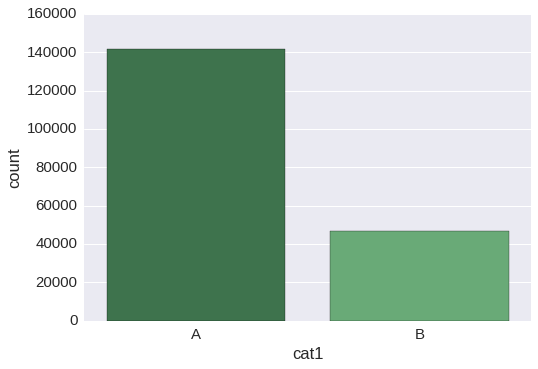

In [13]:
sns.countplot(x='cat1', data=train, palette="Greens_d")

In [14]:
cat_lbl = []
for cat in cat_not_ab:
    if cat.startswith("cat"):
        cat_lbl.extend(train[cat])
distinct_cat = sorted(set(cat_lbl))
print(distinct_cat)

['A', 'AA', 'AB', 'AC', 'AD', 'AE', 'AF', 'AG', 'AH', 'AI', 'AJ', 'AK', 'AL', 'AM', 'AN', 'AO', 'AP', 'AQ', 'AR', 'AS', 'AT', 'AU', 'AV', 'AW', 'AX', 'AY', 'B', 'BA', 'BB', 'BC', 'BD', 'BE', 'BF', 'BG', 'BH', 'BI', 'BJ', 'BK', 'BL', 'BM', 'BN', 'BO', 'BP', 'BQ', 'BR', 'BS', 'BT', 'BU', 'BV', 'BW', 'BX', 'BY', 'C', 'CA', 'CB', 'CC', 'CD', 'CE', 'CF', 'CG', 'CH', 'CI', 'CJ', 'CK', 'CL', 'CM', 'CN', 'CO', 'CP', 'CQ', 'CR', 'CS', 'CT', 'CU', 'CV', 'CW', 'CX', 'CY', 'D', 'DA', 'DB', 'DC', 'DD', 'DE', 'DF', 'DG', 'DH', 'DI', 'DJ', 'DK', 'DL', 'DM', 'DN', 'DO', 'DP', 'DQ', 'DR', 'DS', 'DT', 'DU', 'DV', 'DW', 'DX', 'DY', 'E', 'EA', 'EB', 'EC', 'ED', 'EE', 'EF', 'EG', 'EH', 'EI', 'EJ', 'EK', 'EL', 'EM', 'EN', 'EO', 'EP', 'EQ', 'ES', 'EU', 'EV', 'EW', 'EY', 'F', 'FA', 'FB', 'FC', 'FD', 'FE', 'FF', 'FG', 'FH', 'FI', 'FJ', 'FK', 'FL', 'FM', 'FN', 'FO', 'FP', 'FQ', 'FR', 'FS', 'FT', 'FU', 'FV', 'FW', 'FX', 'G', 'GA', 'GB', 'GC', 'GD', 'GE', 'GF', 'GG', 'GH', 'GI', 'GJ', 'GK', 'GL', 'GM', 'GN', 'GO'

This looks like some sort of columns on Excel, with some columns missing, such as `Z`, `AZ`, and so one. The very last one is here, `ZZ`, but this looks like so much as missing

In [15]:
"TA" not in distinct_cat

True

Let's consider each category are being completely independent. We need to encode into numerical values

In [16]:
# Concatenate the training set and test set into a single table, 
# so "factorize" will cover the complete data set
# (in case there are new categories in the test set)

ntrain = train_clean.shape[0]
train_test = pd.concat((train_clean, test_clean)).reset_index(drop=True)
train_test.tail()
# in `train_test` dataset, there are `ntrain` lines of the training set, and the rest is the test set

features = train.columns

cats = [feat for feat in features if 'cat' in feat]
for feat in cats:
    train_test[feat] = pd.factorize(train_test[feat], sort=True)[0]

x_train = train_test.iloc[:ntrain,:]
x_test = train_test.iloc[ntrain:,:]

We now have 2 datasets (training and test) with only numerical features. `catX` represents categories id, `contX` and discrete numerical features.

In [17]:
x_train.head()

,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,cat11,cat12,cat13,cat14,cat15,cat16,cat17,cat18,cat19,cat20,cat21,cat22,cat23,cat24,cat25,cat26,cat27,cat28,cat29,cat30,cat31,cat32,cat33,cat34,cat35,cat36,cat37,cat38,cat39,cat40,cat41,cat42,cat43,cat44,cat45,cat46,cat47,cat48,cat49,cat50,cat51,cat52,cat53,cat54,cat55,cat56,cat57,cat58,cat59,cat60,cat61,cat62,cat63,cat64,cat65,cat66,cat67,cat68,cat69,cat70,cat71,cat72,cat73,cat74,cat75,cat76,cat77,cat78,cat79,cat80,cat81,cat82,cat83,cat84,cat85,cat86,cat87,cat88,cat89,cat90,cat91,cat92,cat93,cat94,cat95,cat96,cat97,cat98,cat99,cat100,cat101,cat102,cat103,cat104,cat105,cat106,cat107,cat108,cat109,cat110,cat111,cat112,cat113,cat114,cat115,cat116,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14
0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,3,1,1,3,3,1,3,2,1,3,1,0,0,0,0,0,3,1,2,4,0,2,15,1,6,0,0,8,4,6,9,6,46,28,2,19,57,0,14,288,0.726300,0.245921,0.187583,0.789639,0.310061,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843
1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,1,1,3,3,0,1,2,1,3,1,0,0,0,0,0,3,3,2,4,4,3,15,11,5,0,0,4,4,8,10,10,34,67,0,22,39,0,14,94,0.330514,0.737068,0.592681,0.614134,0.885834,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496
2,0,1,0,0,1,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,1,1,1,3,1,3,2,1,1,1,0,0,0,0,0,3,3,2,4,4,0,1,11,14,0,1,4,5,7,5,0,2,87,0,28,6,0,8,167,0.261841,0.358319,0.484196,0.236924,0.397069,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425
3,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,3,1,1,3,3,3,1,2,1,3,1,0,0,0,0,0,3,3,2,4,4,3,15,8,3,0,0,4,4,8,10,10,34,69,2,39,5,0,14,88,0.321594,0.555782,0.527991,0.373816,0.422268,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642
4,0,1,0,1,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,3,1,3,1,3,1,1,2,1,1,2,0,0,0,1,7,3,1,3,4,4,0,12,5,9,0,0,3,4,10,6,1,67,51,2,50,39,0,10,63,0.273204,0.159990,0.527991,0.473202,0.704268,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606


In [18]:
x_test.head()

,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,cat11,cat12,cat13,cat14,cat15,cat16,cat17,cat18,cat19,cat20,cat21,cat22,cat23,cat24,cat25,cat26,cat27,cat28,cat29,cat30,cat31,cat32,cat33,cat34,cat35,cat36,cat37,cat38,cat39,cat40,cat41,cat42,cat43,cat44,cat45,cat46,cat47,cat48,cat49,cat50,cat51,cat52,cat53,cat54,cat55,cat56,cat57,cat58,cat59,cat60,cat61,cat62,cat63,cat64,cat65,cat66,cat67,cat68,cat69,cat70,cat71,cat72,cat73,cat74,cat75,cat76,cat77,cat78,cat79,cat80,cat81,cat82,cat83,cat84,cat85,cat86,cat87,cat88,cat89,cat90,cat91,cat92,cat93,cat94,cat95,cat96,cat97,cat98,cat99,cat100,cat101,cat102,cat103,cat104,cat105,cat106,cat107,cat108,cat109,cat110,cat111,cat112,cat113,cat114,cat115,cat116,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14
188318,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,1,1,3,3,1,1,2,1,3,1,0,0,0,0,0,3,2,2,4,2,3,15,7,6,0,0,6,4,8,11,10,34,28,0,35,24,0,16,189,0.321594,0.299102,0.246911,0.402922,0.281143,0.466591,0.317681,0.61229,0.34365,0.38016,0.377724,0.369858,0.704052,0.392562
188319,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,3,1,1,3,3,1,1,2,1,1,1,0,0,0,0,0,3,3,3,4,0,0,12,1,3,0,0,6,6,6,5,1,34,65,4,32,61,0,11,193,0.634734,0.620805,0.654310,0.946616,0.836443,0.482425,0.443760,0.71330,0.51890,0.60401,0.689039,0.675759,0.453468,0.208045
188320,0,1,0,1,1,0,1,0,1,1,0,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3,1,1,1,1,1,3,2,1,1,1,0,1,0,0,0,3,3,2,4,4,0,1,6,15,0,3,3,4,9,6,0,34,69,2,46,5,0,10,63,0.290813,0.737068,0.711159,0.412789,0.718531,0.212308,0.325779,0.29758,0.34365,0.30529,0.245410,0.241676,0.258586,0.297232
188321,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,3,1,3,1,3,1,1,0,1,3,3,0,0,0,6,7,3,3,2,4,4,3,15,6,0,0,3,4,4,8,10,10,34,68,0,25,10,0,15,88,0.268622,0.681761,0.592681,0.354893,0.397069,0.369930,0.342355,0.40028,0.33237,0.31480,0.348867,0.341872,0.592264,0.555955
188322,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,1,1,3,3,1,1,2,1,1,1,0,0,0,0,0,3,1,3,4,0,0,12,0,0,0,0,5,4,6,4,1,2,108,0,30,47,2,9,183,0.553846,0.299102,0.263570,0.696873,0.302678,0.398862,0.391833,0.23688,0.43731,0.50556,0.359572,0.352251,0.301535,0.825823


Let's look at the numerical features

# Numerical Features

In [19]:
train.describe()

,id,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
count,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000
mean,294135.982561,0.493861,0.507188,0.498918,0.491812,0.487428,0.490945,0.484970,0.486437,0.485506,0.498066,0.493511,0.493150,0.493138,0.495717,3037.337686
std,169336.084867,0.187640,0.207202,0.202105,0.211292,0.209027,0.205273,0.178450,0.199370,0.181660,0.185877,0.209737,0.209427,0.212777,0.222488,2904.086186
min,1.000000,0.000016,0.001149,0.002634,0.176921,0.281143,0.012683,0.069503,0.236880,0.000080,0.000000,0.035321,0.036232,0.000228,0.179722,0.670000
25%,147748.250000,0.346090,0.358319,0.336963,0.327354,0.281143,0.336105,0.350175,0.312800,0.358970,0.364580,0.310961,0.311661,0.315758,0.294610,1204.460000
50%,294539.500000,0.475784,0.555782,0.527991,0.452887,0.422268,0.440945,0.438285,0.441060,0.441450,0.461190,0.457203,0.462286,0.363547,0.407403,2115.570000
75%,440680.500000,0.623912,0.681761,0.634224,0.652072,0.643315,0.655021,0.591045,0.623580,0.566820,0.614590,0.678924,0.675759,0.689974,0.724623,3864.045000
max,587633.000000,0.984975,0.862654,0.944251,0.954297,0.983674,0.997162,1.000000,0.980200,0.995400,0.994980,0.998742,0.998484,0.988494,0.844848,121012.250000


Is there NaN or None value?

In [20]:
null_values = 0
for k in train.columns:
    n = sum(train[k].isnull())
    if n != 0:    
        print("col {}: {}".format(k, n))
        null_values += 1
if null_values == 0:
    print("No NaN/None Values")

No NaN/None Values


In [59]:
def correlation_matrix(df):
    correlations = df.corr()

    # Generate a mask for the upper triangle
    mask = np.zeros_like(correlations, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    
    if df.shape[1] > 20:
        nticklabels = 5
    else:
        nticklabels = 2

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(correlations,
                mask=mask,
                cmap=cmap,
                vmax=.3,
                square=True,
                xticklabels=nticklabels,
                yticklabels=nticklabels,
                #linewidths=0.01,
                cbar_kws={"shrink": 0.8},
                ax=ax)

How does categories correlate each other?

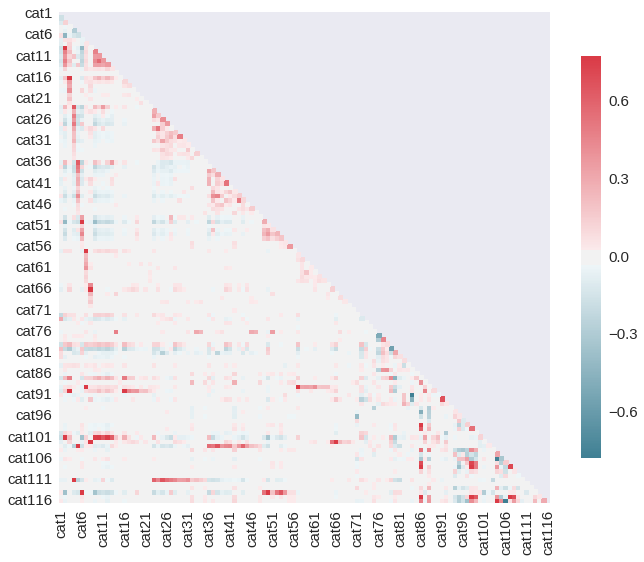

In [54]:
correlation_matrix(x_train[cats])

And display the correlation matrix for numerical features

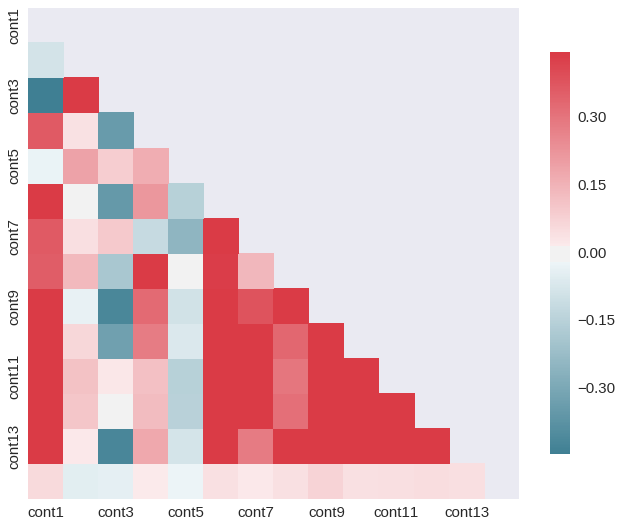

In [63]:
correlation_matrix(x_train[conts])

# Target feature behavior on the Training set

Let's look how the `loss` column in the training dataset looks like. It represents how many the insurance has paid for each event.

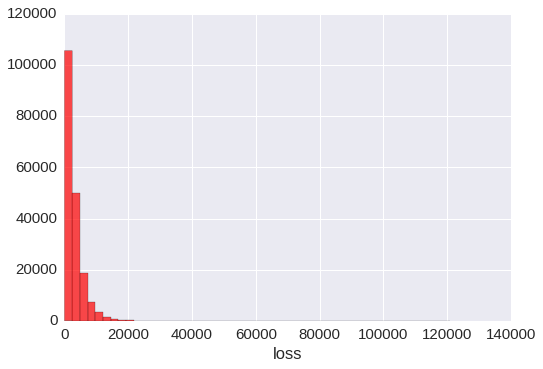

In [24]:
sns.distplot(train['loss'], color = 'r', hist_kws={'alpha': 0.7}, kde = False)

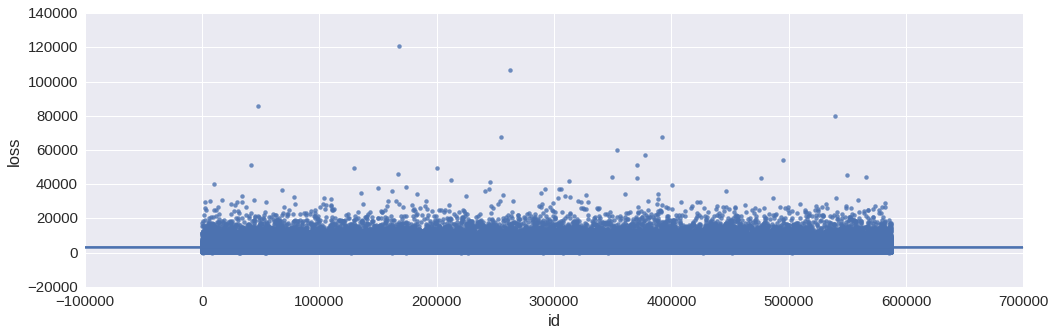

In [25]:
sns.lmplot('id', 'loss', palette='r', aspect=3.0, data=train)

Like we see, there are a few high loss, and many small ones. It is a visualisation of the `describe()` method used earleir:

In [26]:
train['loss'].describe()

count    188318.000000
mean       3037.337686
std        2904.086186
min           0.670000
25%        1204.460000
50%        2115.570000
75%        3864.045000
max      121012.250000
Name: loss, dtype: float64

## Features importances

Which features are meaningful? XGBoost might give use the order of importance for the features

In [27]:
y_train = train["loss"]
y_train.head()

0    2213.18
1    1283.60
2    3005.09
3     939.85
4    2763.85
Name: loss, dtype: float64

In [28]:
x_train.head()

,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,cat11,cat12,cat13,cat14,cat15,cat16,cat17,cat18,cat19,cat20,cat21,cat22,cat23,cat24,cat25,cat26,cat27,cat28,cat29,cat30,cat31,cat32,cat33,cat34,cat35,cat36,cat37,cat38,cat39,cat40,cat41,cat42,cat43,cat44,cat45,cat46,cat47,cat48,cat49,cat50,cat51,cat52,cat53,cat54,cat55,cat56,cat57,cat58,cat59,cat60,cat61,cat62,cat63,cat64,cat65,cat66,cat67,cat68,cat69,cat70,cat71,cat72,cat73,cat74,cat75,cat76,cat77,cat78,cat79,cat80,cat81,cat82,cat83,cat84,cat85,cat86,cat87,cat88,cat89,cat90,cat91,cat92,cat93,cat94,cat95,cat96,cat97,cat98,cat99,cat100,cat101,cat102,cat103,cat104,cat105,cat106,cat107,cat108,cat109,cat110,cat111,cat112,cat113,cat114,cat115,cat116,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14
0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,3,1,1,3,3,1,3,2,1,3,1,0,0,0,0,0,3,1,2,4,0,2,15,1,6,0,0,8,4,6,9,6,46,28,2,19,57,0,14,288,0.726300,0.245921,0.187583,0.789639,0.310061,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843
1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,1,1,3,3,0,1,2,1,3,1,0,0,0,0,0,3,3,2,4,4,3,15,11,5,0,0,4,4,8,10,10,34,67,0,22,39,0,14,94,0.330514,0.737068,0.592681,0.614134,0.885834,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496
2,0,1,0,0,1,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,1,1,1,3,1,3,2,1,1,1,0,0,0,0,0,3,3,2,4,4,0,1,11,14,0,1,4,5,7,5,0,2,87,0,28,6,0,8,167,0.261841,0.358319,0.484196,0.236924,0.397069,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425
3,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,3,1,1,3,3,3,1,2,1,3,1,0,0,0,0,0,3,3,2,4,4,3,15,8,3,0,0,4,4,8,10,10,34,69,2,39,5,0,14,88,0.321594,0.555782,0.527991,0.373816,0.422268,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642
4,0,1,0,1,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,3,1,3,1,3,1,1,2,1,1,2,0,0,0,1,7,3,1,3,4,4,0,12,5,9,0,0,3,4,10,6,1,67,51,2,50,39,0,10,63,0.273204,0.159990,0.527991,0.473202,0.704268,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606


Fine, there is no more the `loss` column inside the `x_train`. This would have angry XGBoost CV.

In [29]:
import xgboost as xgb

dtrain = xgb.DMatrix(x_train, label=y_train.ravel())
dtest = xgb.DMatrix(x_test)

We use XGBoost cross validation to fine tune the hyper parameters.

> Cross-validation combines measures of fit (prediction error) to derive a more accurate estimate of model prediction performance.



In [30]:
num_boost_round_slider.value

6010

In [31]:
seed = 100

xgb_params = {
    'seed': seed,
    'colsample_bytree': 0.7,
    'silent': 1,
    'subsample': 0.7,
    'learning_rate': 0.075,
    'objective': 'reg:linear',
    'max_depth': 6,
    'num_parallel_tree': 1,
    'min_child_weight': 1,
    'eval_metric': 'mae',
}

num_boost_round = num_boost_round_slider.value
early_stopping_rounds = 50

print("Cross validation with max {} rounds".format(num_boost_round))
cv_xgb = xgb.cv(params=xgb_params,
                dtrain=dtrain, 
                num_boost_round=num_boost_round, 
                nfold=4, 
                seed=seed,
                stratified=False,
                early_stopping_rounds=early_stopping_rounds, 
                verbose_eval=10,
                show_stdv=True)

Cross validation with max 6010 rounds
[0]	train-mae:2809.92+5.64101	test-mae:2809.99+18.2833
[10]	train-mae:1543.99+4.75389	test-mae:1548.09+8.3199
[20]	train-mae:1294.99+3.61911	test-mae:1304.48+6.47238
[30]	train-mae:1248.64+2.29672	test-mae:1263.69+6.58648
[40]	train-mae:1232.04+2.06804	test-mae:1251.44+6.81029
[50]	train-mae:1217.44+1.81362	test-mae:1240.88+6.82035
[60]	train-mae:1203.53+1.93867	test-mae:1230.62+7.19211
[70]	train-mae:1190.98+1.5284	test-mae:1221.12+6.75626
[80]	train-mae:1180.86+1.77853	test-mae:1214.43+6.70768
[90]	train-mae:1172.92+1.86366	test-mae:1209.26+6.80731
[100]	train-mae:1166.28+1.91358	test-mae:1205.23+6.90054
[110]	train-mae:1160.45+1.76872	test-mae:1201.99+7.18997
[120]	train-mae:1155.36+1.86286	test-mae:1199.25+7.08191
[130]	train-mae:1150.79+2.08144	test-mae:1196.97+6.94793
[140]	train-mae:1146.76+2.1454	test-mae:1195.15+6.78979
[150]	train-mae:1143.23+2.13638	test-mae:1193.74+7.15403
[160]	train-mae:1140.07+2.29713	test-mae:1192.78+7.18052
[170]	t

As we seen, the CV stops after several hundreds of iterations (670) because of the `early_stopping_rounds` that stop the loop if no progress are made anymore.

The max seems to be on round 622 with an error of 1181.
On the Kaggle Leader Board (that compares the prediction on the test set against the **real** answer), the score is 1162.

In [32]:
cv_xgb.tail(3)

,test-mae-mean,test-mae-std,train-mae-mean,train-mae-std
620,1181.867493,6.757240,1045.678559,3.002574
621,1181.851593,6.737389,1045.495453,3.017354
622,1181.845825,6.749685,1045.326996,3.016564


In [33]:
display(cv_xgb[:10])
display(cv_xgb[-10:])

,test-mae-mean,test-mae-std,train-mae-mean,train-mae-std
0,2809.986633,18.283345,2809.917602,5.641009
1,2601.661682,17.259479,2601.351196,5.463688
2,2412.457153,16.227658,2411.979492,5.154560
3,2243.151672,14.877908,2242.177307,5.088957
4,2093.309998,14.151144,2091.973633,4.314989
5,1962.783631,12.972117,1960.985138,4.441649
6,1850.293548,12.199577,1848.273071,4.174844
7,1755.191864,10.616186,1752.561279,4.690840
8,1674.451782,10.030079,1671.189911,4.530100
9,1605.869049,9.170800,1602.315064,4.449814


,test-mae-mean,test-mae-std,train-mae-mean,train-mae-std
613,1181.870849,6.722525,1046.804566,2.993439
614,1181.902740,6.758929,1046.673126,2.965734
615,1181.889404,6.770089,1046.494812,2.996884
616,1181.893250,6.771696,1046.355163,2.980854
617,1181.911316,6.777554,1046.189239,2.974065
618,1181.884888,6.760100,1046.036713,2.982124
619,1181.865631,6.737626,1045.832855,3.010901
620,1181.867493,6.757240,1045.678559,3.002574
621,1181.851593,6.737389,1045.495453,3.017354
622,1181.845825,6.749685,1045.326996,3.016564


How far will we go with this approach?

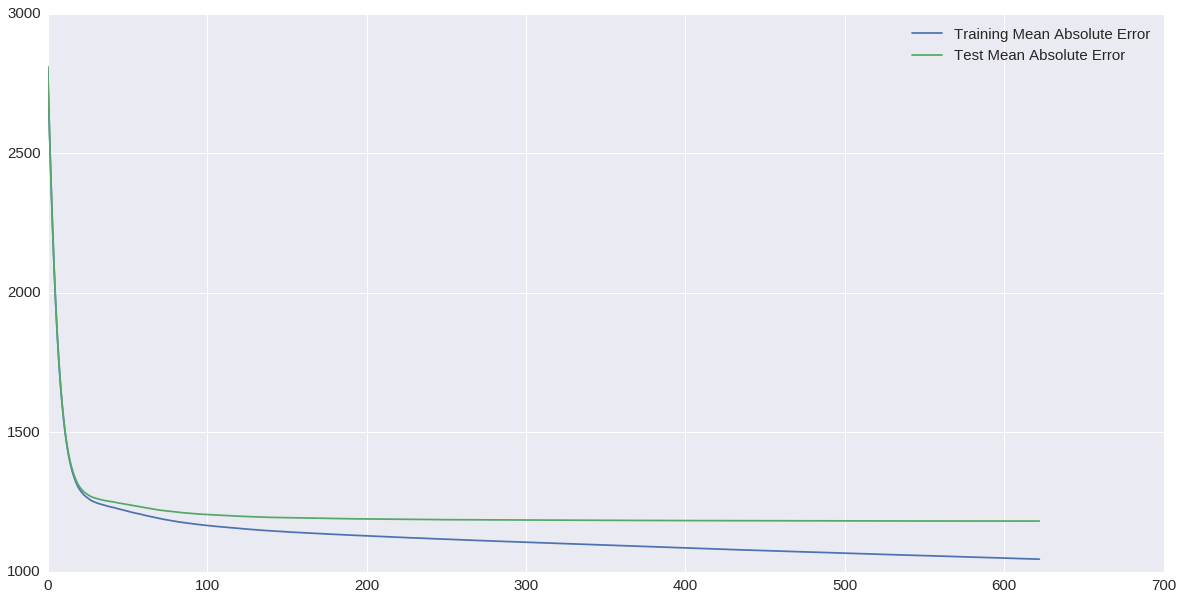

In [62]:
sns.set_style("darkgrid")
plt.figure(figsize=(20, 10))
plt.plot(cv_xgb['train-mae-mean'], label='Training Mean Absolute Error')
plt.plot(cv_xgb['test-mae-mean'], label='Test Mean Absolute Error')
plt.legend()
plt.show()

The "test" seems indeed so flat, we won't go too far with this algorithm. And we do not want to overfit our model.

In [50]:
best_nrounds = cv_xgb.shape[0] - 1
cv_mean = cv_xgb.iloc[-1, 0]
cv_std = cv_xgb.iloc[-1, 1]
print('Cross Validation Best score: {0} (std deviation: {1}) at round {2}'.format(cv_mean, cv_std, best_nrounds))

Cross Validation Best score: 1181.8458249999999 (std deviation: 6.749684659396862) at round 622


We now have our trained boosted tree. Let's find out which are the most important features.

Let's train our model at the best round

In [51]:
gbdt = xgb.train(xgb_params, dtrain, best_nrounds)

Retrieve the feature score to build the feature importance matrix.

In [36]:
importance_matrix = gbdt.get_fscore()

importance_df = pd.DataFrame({'Importance': list(importance_matrix.values()), 'Feature': list(importance_matrix.keys())})
importance_df.sort_values(by = 'Importance', inplace = True)
most_importance_features = importance_df[-10:-1]

And plot this importance matrix

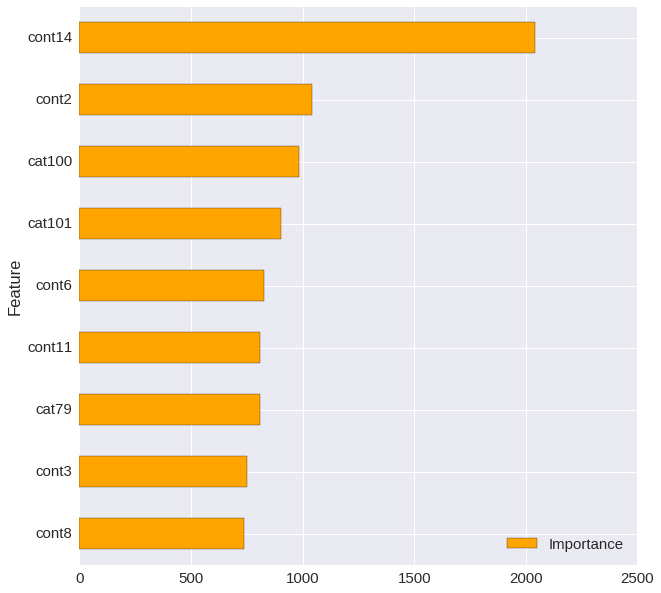

In [52]:
most_importance_features.plot(kind='barh', x='Feature', figsize=(10,10), color='orange')

According to XBG CV, the `loss` is actually highly correlated with the `cont14` and `cont2` features.

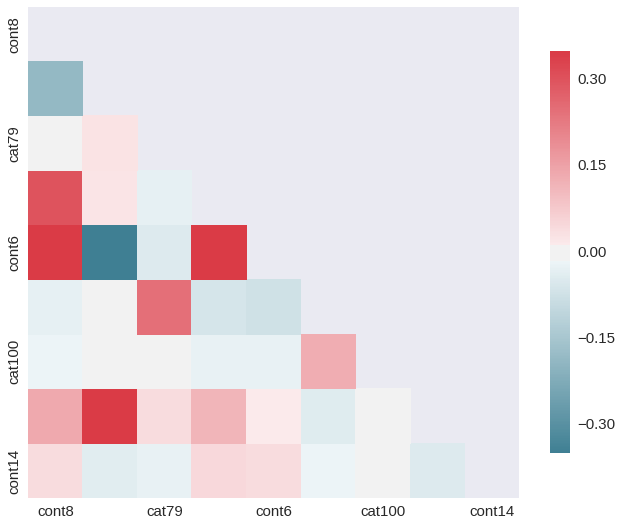

In [60]:
correlation_matrix(x_train[list(most_importance_features["Feature"])])

# Test Prediction

We now are ready to predict some results. But first, let's evaluate the accuration of the model against the training set.

We will "predict" the loss of the training set, and compare against the `loss` column.

In [39]:
train_predictions = gbdt.predict(dtrain)

In [40]:
print("Train loss: ", [y for y in y_train[:10]])
print("Predictect train loss: ", [p for p in train_predictions[:10]])

Train loss:  [2213.1799999999998, 1283.5999999999999, 3005.0900000000001, 939.85000000000002, 2763.8499999999999, 5142.8699999999999, 1132.22, 3585.75, 10280.200000000001, 6184.5900000000001]
Predictect train loss:  [1765.333, 2150.2981, 4368.6128, 1090.9895, 3351.7109, 4936.8481, 1217.9144, 6590.833, 8827.3916, 6003.5879]


In [41]:
# evaluate predictions
from sklearn.metrics import mean_absolute_error
accuracy = mean_absolute_error([int(v) for v in y_train.ravel()], [int(p) for p in train_predictions])
accuracy

1067.6092832336792

In [42]:
test_predictions = gbdt.predict(dtest)

In [43]:
import datetime
today = datetime.date.today()

date_tag = today.strftime('%Y%m%d')
date_tag

'20161012'

In [44]:
submission = pd.DataFrame({"id": test.id.values,
                           "loss": test_predictions})
submission.head(10)

,id,loss
0,4,1688.128174
1,6,2110.000488
2,9,10111.648438
3,12,6413.117188
4,15,981.893433
5,17,2487.134766
6,21,2400.275391
7,28,899.604980
8,32,2673.984863
9,43,3654.003662


In [45]:
submission[['id', 'loss']].to_csv('submition_{}.csv'.format(date_tag),
                                  index=False)